# SYSID - Trabalho (ML - MISO.LM)

Alunos: 

Pedro Henrique Cardoso Paulo</br>
Felipe da Costa Pereira

Professor: Helon

## Objetivo

TBD

## Passo 0 - Importando bibliotecas

In [1]:
# Pacotes padrao
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime

#Pipeline
from sklearn.pipeline import Pipeline

#Tratamento
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#Modelos
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

#Interface SYSID
from SYSIDPreProcessor import SYSIDRegressor

# Modelos
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold

# Scores
from sklearn.metrics import r2_score

# Disabling warnings
import warnings
from sklearn.exceptions import DataConversionWarning

#Definindo random_state
rs = 85

## Passo 0 - Importando os dados

### 0.1 - Lendo dados

In [2]:
binary = os.path.join(os.getcwd(), 'data', 'volve_compiled.pkl')
print(binary)

with open(binary, 'rb') as bin_file:
    data = pickle.load(bin_file)

/mnt/d/OneDrive/Mestrado/Semestre 02/SYSID/SYSID_trabalho/Volve-Dataset/data/volve_compiled.pkl


In [3]:
for wellp in data['OP'].keys():
    print(wellp)

15/9-F-1 C
15/9-F-11
15/9-F-12
15/9-F-14
15/9-F-15 D
15/9-F-5


### 0.2 - Visualizando dados

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


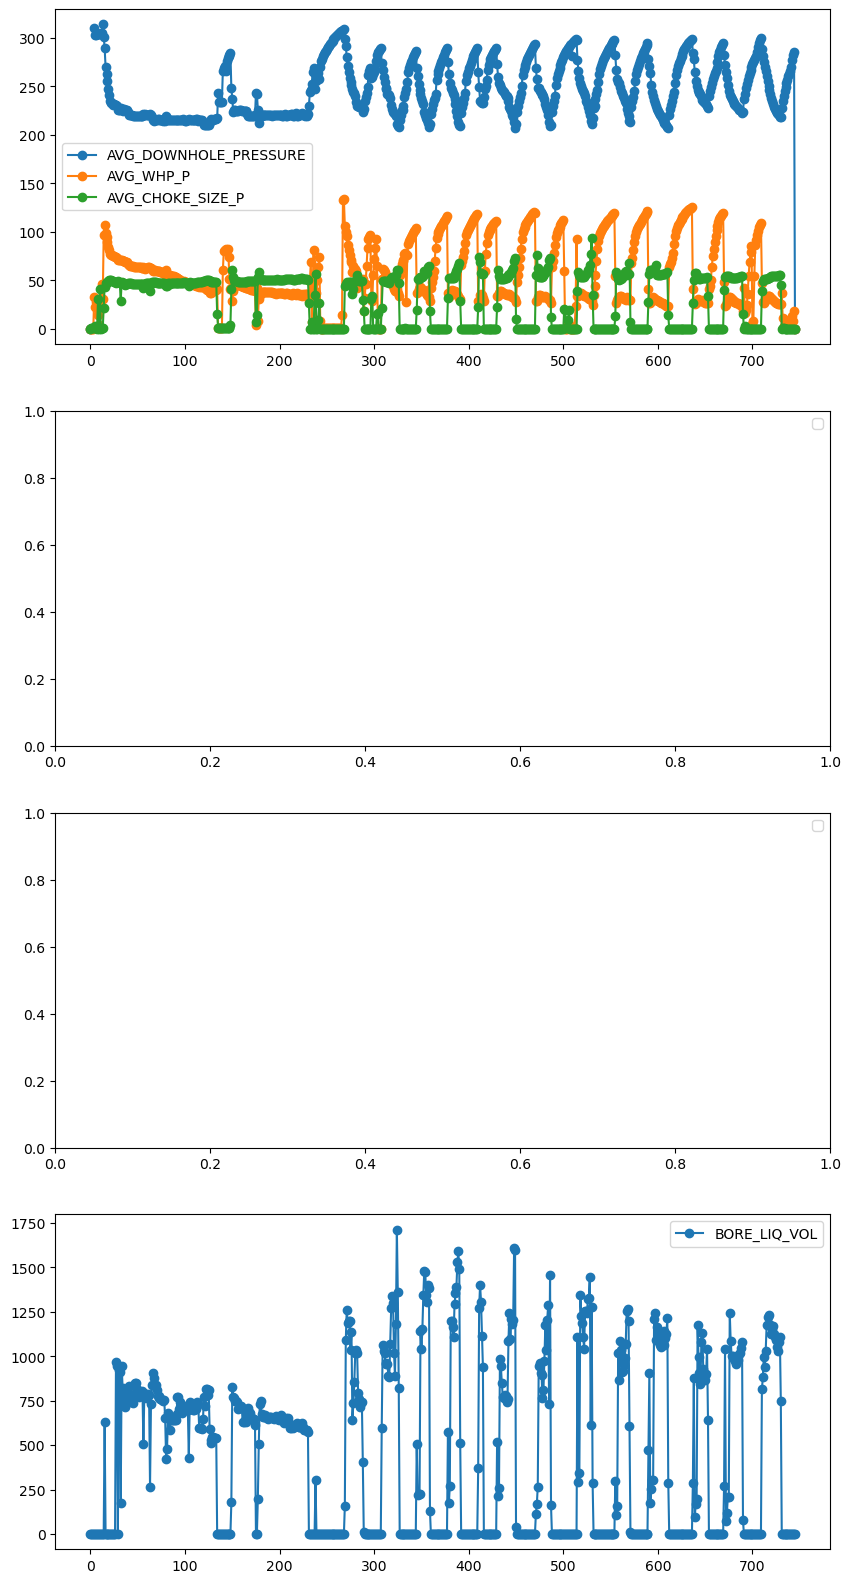

In [4]:
case = "15/9-F-1 C"
#case = "15/9-F-11"

data_case = data['OP'][case]

filt_vars_IN_Q =  [
        #'BORE_OIL_VOL',
        #'BORE_GAS_VOL',
        #'BORE_WAT_VOL',
        #'BORE_OIL_CUM',
        #'BORE_LIQ_CUM',
        #'BORE_GAS_CUM',
        #'BORE_WAT_CUM',
]

filt_vars_IN_QINJ = [
        'BORE_WI_VOL',
        'BORE_WI_CUM',
]

filt_vars_IN_P = [
        'AVG_DOWNHOLE_PRESSURE',
        'AVG_WHP_P',
        #'AVG_DP_TUBING',
        #'AVG_ANNULUS_PRESS',
        'AVG_CHOKE_SIZE_P',
        #'DP_CHOKE_SIZE',
]

filt_vars_IN_T = [
        #'AVG_WHT_P',
        #'AVG_DOWNHOLE_TEMPERATURE',
]

filt_vars_OUT = [
        #'BORE_OIL_VOL',
        'BORE_LIQ_VOL',
        #'BORE_GAS_VOL',
        #'BORE_WAT_VOL',
]

time = data_case['N']
fig, ax = plt.subplots(4,1, figsize=(10, 20))
for var in filt_vars_IN_P:
    ax[0].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_IN_Q:
    ax[1].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_IN_T:
    ax[2].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_OUT:
    ax[3].plot(time, data_case[var], '-o', label=var)
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

In [5]:
data_case = data_case.loc[28:,:]
#data_case = data_case[data_case['AVG_DOWNHOLE_PRESSURE']>0]
data_case = data_case[filt_vars_IN_Q + filt_vars_IN_P + filt_vars_IN_T + filt_vars_OUT].dropna()
X1 = data_case[filt_vars_IN_Q + filt_vars_IN_P + filt_vars_IN_T].values
y =  data_case[filt_vars_OUT].values

## Passo 1 - Separando os dados em treino e teste

### 1.1 - Definindo a parcela de treino e de teste

In [6]:
p_train = 0.8 #80% treino

### 1.2 - Separando os conjuntos

In [7]:
n_train = int(X1.shape[0]*p_train)
X1_tr = X1[:n_train,:]
y_tr = y[:n_train,:]
X1_te = X1[n_train:,:]
y_te = y[n_train:,:]

In [8]:
print(
    X1_tr.shape,
    X1_te.shape
)

(574, 3) (144, 3)


In [9]:
y_scale = MinMaxScaler()
y_tr = y_scale.fit_transform(y_tr)
y_te = y_scale.transform(y_te)

In [10]:
models = [
    ('LinReg',  LinearRegression(copy_X=True)),
    ('SVM',     SVR(max_iter=-1)),
    ('KNN',     KNeighborsRegressor()),
    ('DT',      DecisionTreeRegressor(random_state=rs)),
    ('RF',      RandomForestRegressor(random_state=rs)),
]

n_models = len(models)

In [11]:
parameters = [
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'positive'            : [True, False],
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'C'                     : stats.loguniform(1e-3, 1e3),
        'kernel'                : ['poly', 'rbf', 'sigmoid','linear'],
        'degree'                : stats.randint(2,6),
        'gamma'                 : stats.loguniform(1e-4, 1e0),
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_neighbors'           : stats.randint(1,100),
        'weights'               : ['uniform', 'distance'],
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        #'DT__criterion'              : ['gini', 'entropy'],
        'splitter'               : ['best', 'random'],
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_estimators'           : stats.randint(5,100), #Numero de arvores
        #'RF__criterion'              : ['gini', 'entropy'],
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
]

In [12]:
#t_tr = np.arange(570)
#tmax = np.max(t_tr)
#nfolds = 3
#rkf = [
#    ((t_tr <= tmax/3),(tmax/3 < t_tr)&(t_tr <= 2*tmax/3),),
#    ((tmax/3 < t_tr)&(t_tr <= 2*tmax/3),(2*tmax/3 < t_tr),),
#]
kfolds = 5
niters = 10
rkf = RepeatedKFold(n_splits=kfolds, n_repeats=niters, random_state=71)

In [13]:
results = {
    'MODEL':[],
    'R2 TRAIN':[],
    'R2 TEST':[],
    'MODEL OBJ':[],
    'PARS':[]
}

Iniciando avaliação do modelo: LinReg
Fitting 50 folds for each of 2 candidates, totalling 100 fits

    Tempo de execução: 0:00:02.817004
    Minimum  error: -0.43686909780514904
    Maximum  error: 0.5009169829133915
    R2 score (Train): 0.575418348218543
    R2 score (Test): 0.6679679311374405

    Resultados dos parâmetros:
        Parâmetro positive: True

Iniciando avaliação do modelo: SVM
Fitting 50 folds for each of 100 candidates, totalling 5000 fits

    Tempo de execução: 0:01:59.723910
    Minimum  error: -0.509730932164798
    Maximum  error: 0.44078059062504865
    R2 score (Train): 0.5343889521200276
    R2 score (Test): 0.6125570854530508

    Resultados dos parâmetros:
        Parâmetro C: 1.287199135690017
        Parâmetro degree: 4
        Parâmetro gamma: 0.016299007261940803
        Parâmetro kernel: rbf

Iniciando avaliação do modelo: KNN
Fitting 50 folds for each of 100 candidates, totalling 5000 fits

    Tempo de execução: 0:00:06.116964
    Minimum  error: -

/home/pedro-linux/miniconda3/envs/control/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/pedro-linux/miniconda3/envs/control/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/pedro-linux/miniconda3/envs/control/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/pedro-linux/miniconda3/envs/control/lib/


    Tempo de execução: 0:05:09.183349
    Minimum  error: -0.3182956833231392
    Maximum  error: 0.6081229055233135
    R2 score (Train): 0.5730180603474098
    R2 score (Test): 0.4714534169001635

    Resultados dos parâmetros:
        Parâmetro max_depth: 15
        Parâmetro max_features: 0.4383318767977059
        Parâmetro max_leaf_nodes: 56
        Parâmetro min_samples_leaf: 4
        Parâmetro min_samples_split: 18
        Parâmetro n_estimators: 70



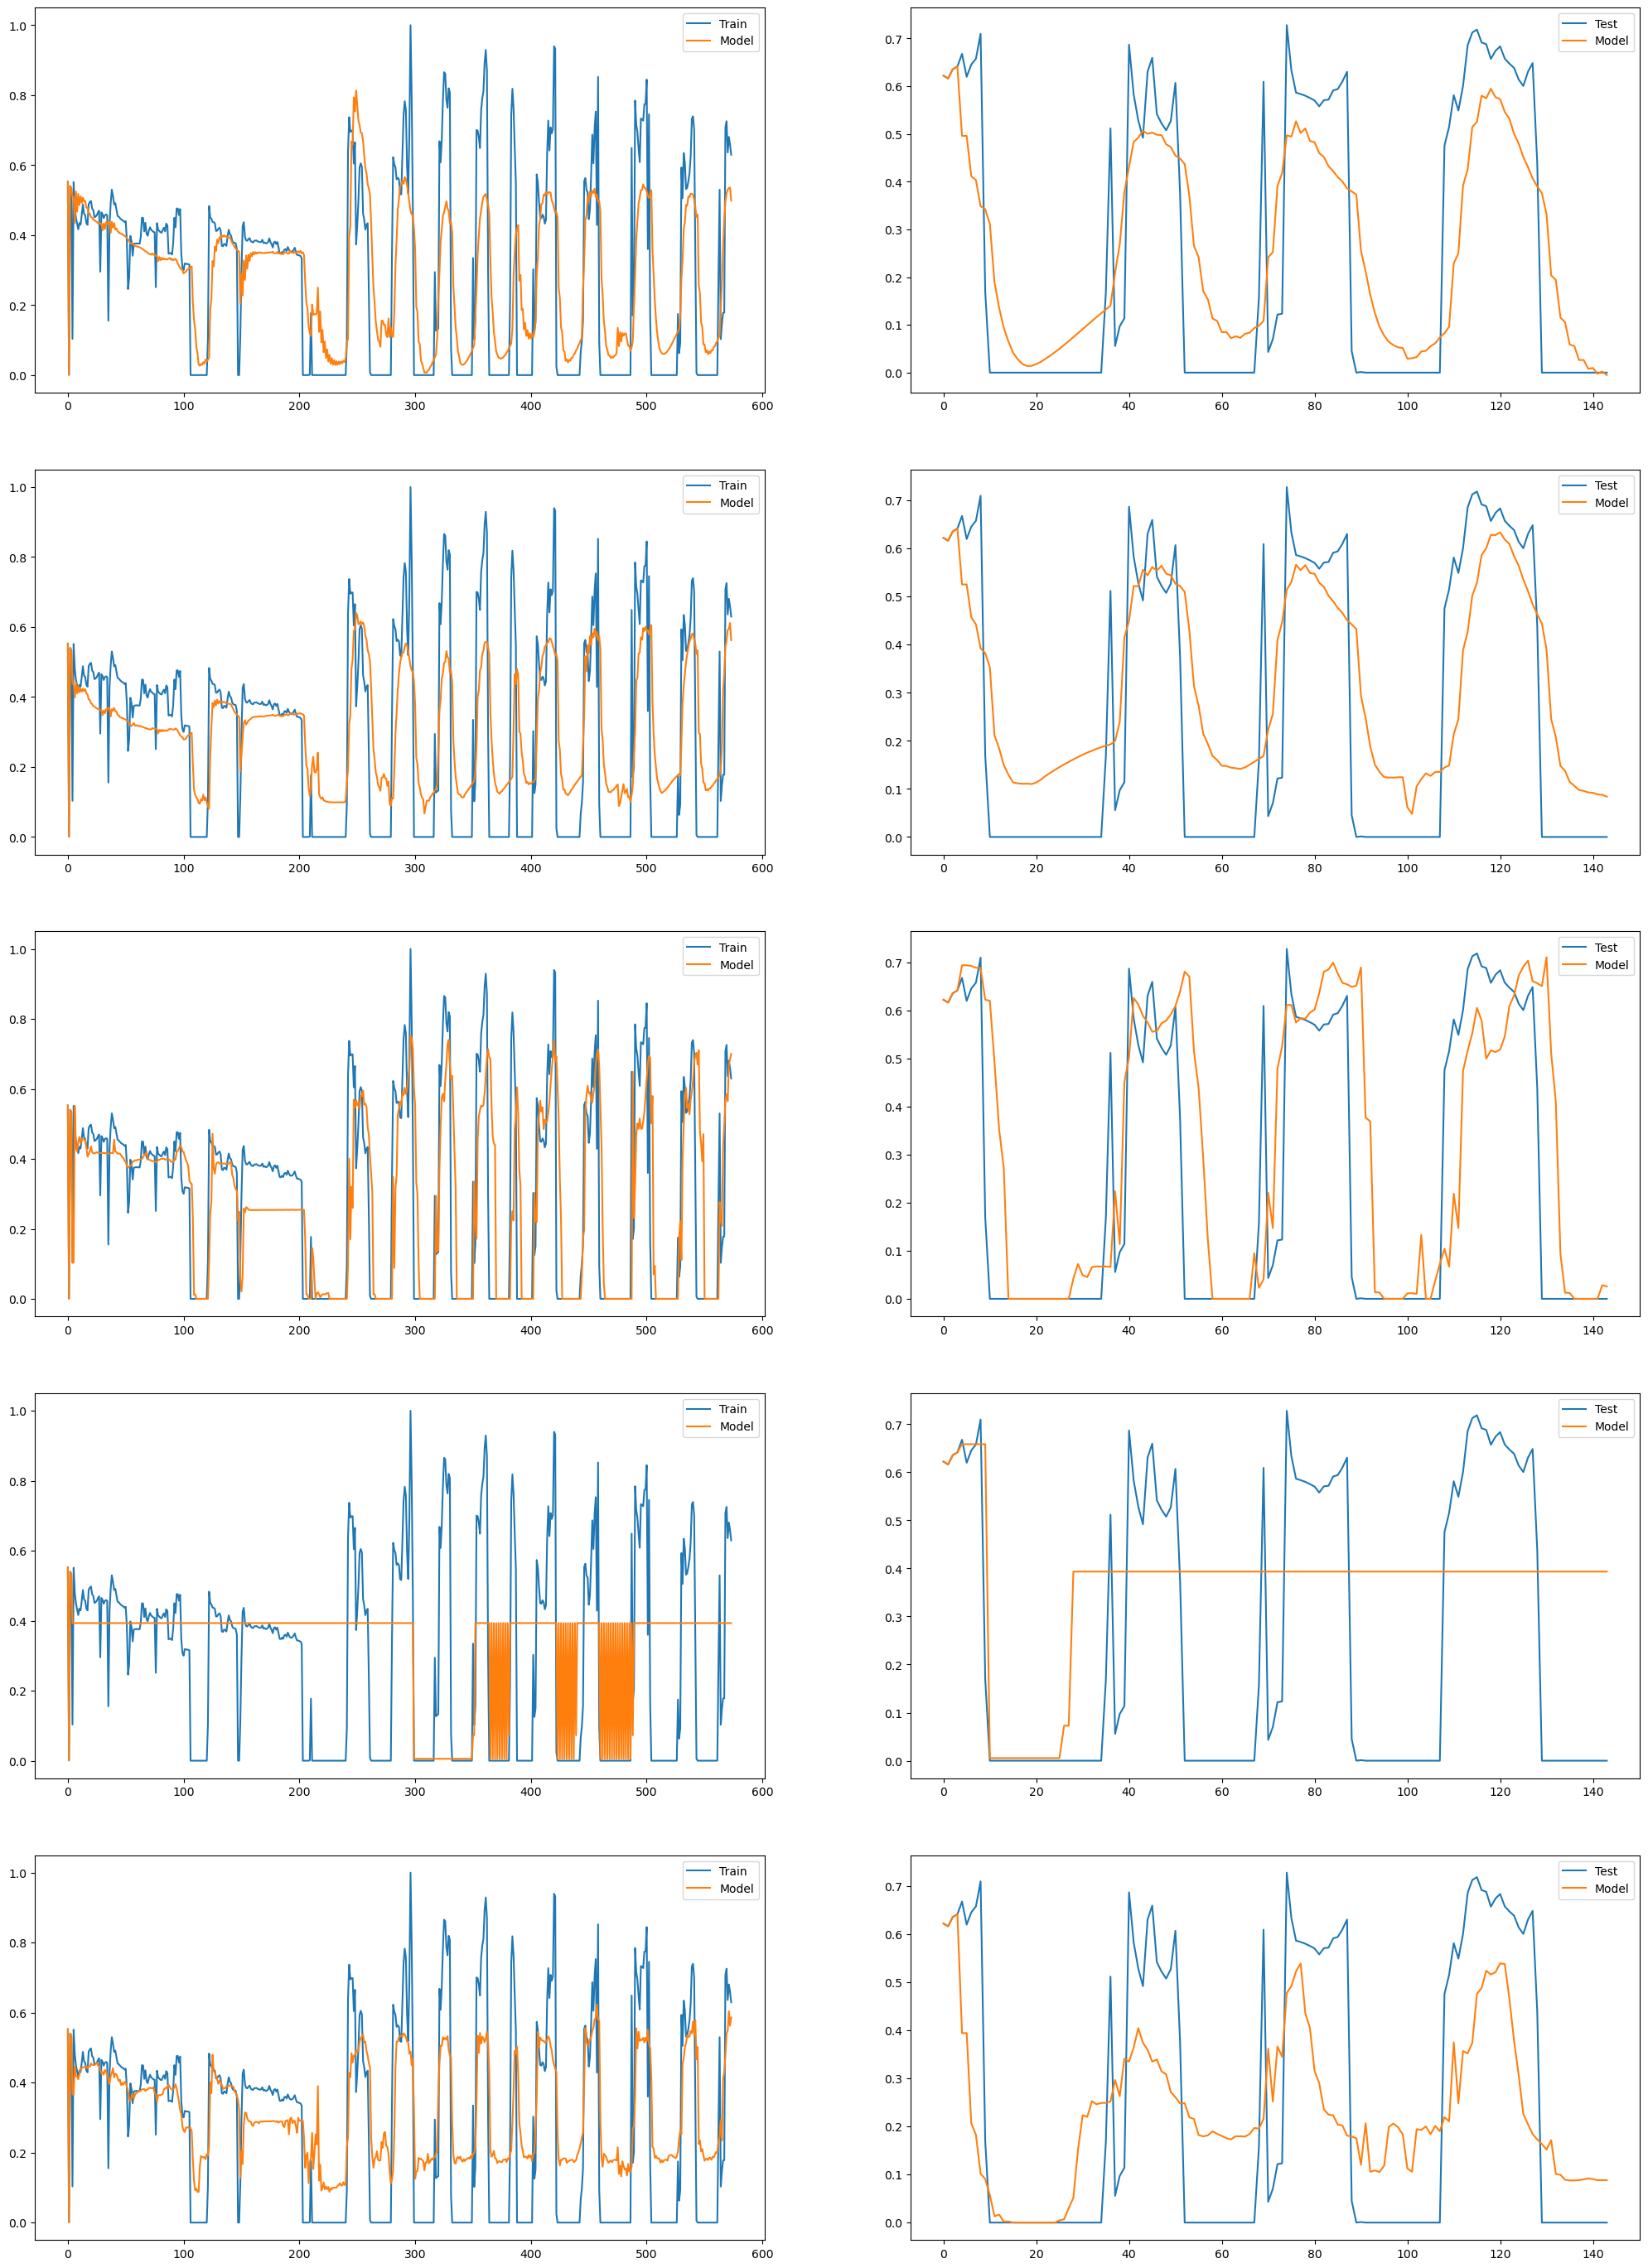

In [14]:
n_iter = 100 #Numero de iterações do rdmsearch 

fig, axs = plt.subplots(ncols=2, nrows=n_models, figsize=(25,n_models*7))

#Loop principal, iterando sobre as listas
for model, params, ax in zip(models, parameters, axs):
    
    #print(params)
    model_name = model[0]
    model_bin = model[1]
    print('Iniciando avaliação do modelo: {}'.format(model_name))

    rdmsearch = RandomizedSearchCV(model_bin, verbose=1, scoring='r2', 
                                   param_distributions=params, n_iter=n_iter, n_jobs=6, 
                                   cv=rkf, random_state=rs)
    
    sidmodel = SYSIDRegressor(
        nX=4, ny=4,
        estimator=rdmsearch, 
        preprocessor=MinMaxScaler(),
        expansor=PolynomialFeatures(degree=2)
        )
    
    t0 = datetime.now()
    
    #
        
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sidmodel.fit(X1_tr, y_tr)
    
    print()
    print('    Tempo de execução: {}'.format(datetime.now() - t0))
    error = (y_te - sidmodel.predict(X1_te, y=y_te))
    print('    Minimum  error:', error.min())
    print('    Maximum  error:', error.max())
    r2_tr = r2_score(y_tr, sidmodel.predict(X1_tr, y=y_tr))
    r2_te = r2_score(y_te, sidmodel.predict(X1_te, y=y_te))
    print('    R2 score (Train):', r2_tr)
    print('    R2 score (Test):', r2_te)
    hist = ax[0].plot(y_tr, label='Train')
    hist = ax[0].plot(sidmodel.predict(X1_tr, y=y_tr), label='Model')
    ax[0].legend()
    hist = ax[1].plot(y_te, label='Test')
    hist = ax[1].plot(sidmodel.predict(X1_te, y=y_te), label='Model')
    ax[1].legend()
    print()
    print('    Resultados dos parâmetros:')
    for par in sidmodel.estimator.best_params_.keys():
        print('        Parâmetro {}: {}'.format(par, sidmodel.estimator.best_params_[par]))  
    print()
    results['MODEL'].append(model_name)
    results['R2 TRAIN'].append(r2_tr)
    results['R2 TEST'].append(r2_te)
    results['MODEL OBJ'].append(sidmodel)
    results['PARS'].append(sidmodel.estimator.best_params_)

In [15]:
pd.DataFrame(results)

,MODEL,R2 TRAIN,R2 TEST,MODEL OBJ,PARS
0,LinReg,0.575418,0.667968,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,{'positive': True}
1,SVM,0.534389,0.612557,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,"{'C': 1.287199135690017, 'degree': 4, 'gamma':..."
2,KNN,0.503593,0.391623,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,"{'n_neighbors': 9, 'weights': 'distance'}"
3,DT,-0.024635,0.022026,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,"{'max_depth': 2, 'max_features': 0.27448199621..."
4,RF,0.573018,0.471453,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,"{'max_depth': 15, 'max_features': 0.4383318767..."
